# Phylogenetic trees

### Info/doc
- Docu: https://www.khanacademy.org/science/high-school-biology/hs-evolution/hs-phylogeny/a/phylogenetic-trees
- Formatos: 
    - xml: http://phyloxml.org/
    - newick: http://scikit-bio.org/docs/0.4.1/generated/skbio.io.format.newick.html

### Packages/examples to study
- Biopython: http://biopython.org/DIST/docs/tutorial/Tutorial.html#sec248


### Primer prueba
Seguimos este ejemplo: https://chart-studio.plotly.com/~empet/14834.embed

In [1]:
from Bio import Phylo
import numpy as np
import plotly.graph_objs as go
import ipywidgets as ipw

def get_circular_tree_data(tree, order='level', dist=1, start_angle=0, end_angle=360, start_leaf='first'):
    """Define  data needed to get the Plotly plot of a circular tree
    """
    # tree:  an instance of Bio.Phylo.Newick.Tree or Bio.Phylo.PhyloXML.Phylogeny
    # order: tree  traversal method to associate polar coordinates to its nodes
    # dist:  the vertical distance between two consecutive leafs in the associated rectangular tree layout
    # start_angle:  angle in degrees representing the angle of the first leaf mapped to a circle
    # end_angle: angle in degrees representing the angle of the last leaf
    # the list of leafs mapped in anticlockwise direction onto circles can be tree.get_terminals() 
    # or its reversed version tree.get_terminals()[::-1]. 
    # start leaf: is a keyword with two possible values"
    # 'first': to map  the leafs in the list tree.get_terminals() onto a circle,
    #         in the counter-clockwise direction
    # 'last': to map  the leafs in the  list, tree.get_terminals()[::-1] 
    
    start_angle *= np.pi/180 # conversion to radians
    end_angle *= np.pi/180
    
    def get_radius(tree):
        """
        Associates to  each clade root its radius, equal to the distance from that clade to the tree root
        returns dict {clade: node_radius}
        """
        node_radius = tree.depths()
        
        #  If the tree did not record  the branch lengths  assign  the unit branch length
        #  (ex: the case of a newick tree "(A, (B, C), (D, E))")
        if not np.count_nonzero(node_radius.values()):
            node_radius = tree.depths(unit_branch_lengths=True)
        return node_radius
   
    
    def get_vertical_position(tree):
        """
        returns a dict {clade: ycoord}, where y-coord is the cartesian y-coordinate 
        of a  clade root in a rectangular phylogram
        
        """
        n_leafs = tree.count_terminals() # Counts the number of tree leafs.
        
        # Assign y-coordinates to the tree leafs
        if start_leaf == 'first':
            node_ycoord = dict((leaf, k) for k, leaf in enumerate(tree.get_terminals()))
        elif start_leaf == 'last':
            node_ycoord = dict((leaf, k) for k, leaf in enumerate(reversed(tree.get_terminals())))
        else:
            raise ValueError("start leaf can be only 'first' or 'last'")
            
        def assign_ycoord(clade):#compute the y-coord for the root of this clade
            for subclade in clade:
                if subclade not in node_ycoord: # if the subclade root hasn't a y-coord yet
                    assign_ycoord(subclade)
            node_ycoord[clade] = 0.5 * (node_ycoord[clade.clades[0]] + node_ycoord[clade.clades[-1]])

        if tree.root.clades:
            assign_ycoord(tree.root)
        return node_ycoord

    node_radius = get_radius(tree)
    node_ycoord = get_vertical_position(tree)
    y_vals = node_ycoord.values()
    ymin, ymax = min(y_vals), max(y_vals)
    ymin -= dist # this dist subtraction is necessary to avoid coincidence of the  first and last leaf angle
                 # when the interval  [ymin, ymax] is mapped onto [0, 2pi],
                
    def ycoord2theta(y):
        # maps an y in the interval [ymin-dist, ymax] to the interval [radian(start_angle), radian(end_angle)]
        
        return start_angle + (end_angle - start_angle) * (y-ymin) / float(ymax-ymin)

    
        

    def get_points_on_lines(linetype='radial', x_left=0, x_right=0, y_right=0,  y_bot=0, y_top=0):
        """
        - define the points that generate a radial branch and the circular arcs, perpendicular to that branch
         
        - a circular arc (angular linetype) is defined by 10 points on the segment of ends
        (x_bot, y_bot), (x_top, y_top) in the rectangular layout,
         mapped by the polar transformation into 10 points that are spline interpolated
        - returns for each linetype the lists X, Y, containing the x-coords, resp y-coords of the
        line representative points
        """
       
        if linetype == 'radial':
            theta = ycoord2theta(y_right) 
            X = [x_left*np.cos(theta), x_right*np.cos(theta), None]
            Y = [x_left*np.sin(theta), x_right*np.sin(theta), None]
        
        elif linetype == 'angular':
            theta_b = ycoord2theta(y_bot)
            theta_t = ycoord2theta(y_top)
            t = np.linspace(0,1, 10)# 10 points that span the circular arc 
            theta = (1-t) * theta_b + t * theta_t
            X = list(x_right * np.cos(theta)) + [None]
            Y = list(x_right * np.sin(theta)) + [None]
        
        else:
            raise ValueError("linetype can be only 'radial' or 'angular'")
       
        return X,Y   
        
    

    def get_line_lists(clade,  x_left,  xlines, ylines, xarc, yarc):
        """Recursively compute the lists of points that span the tree branches"""
        
        # xlines, ylines  - the lists of x-coords, resp y-coords of radial edge ends
        # xarc, yarc - the lists of points generating arc segments for tree branches
        
        x_right = node_radius[clade]
        y_right = node_ycoord[clade]
   
        X,Y = get_points_on_lines(linetype='radial', x_left=x_left, x_right=x_right, y_right=y_right)
   
        xlines.extend(X)
        ylines.extend(Y)
   
        if clade.clades:
           
            y_top = node_ycoord[clade.clades[0]]
            y_bot = node_ycoord[clade.clades[-1]]
       
            X,Y = get_points_on_lines(linetype='angular',  x_right=x_right, y_bot=y_bot, y_top=y_top)
            xarc.extend(X)
            yarc.extend(Y)
       
            # get and append the lists of points representing the  branches of the descedants
            for child in clade:
                get_line_lists(child, x_right, xlines, ylines, xarc, yarc)

    xlines = []
    ylines = []
    xarc = []
    yarc = []
    get_line_lists(tree.root,  0, xlines, ylines, xarc, yarc)  
    xnodes = []
    ynodes = []

    for clade in tree.find_clades(order='preorder'): #it was 'level'
        theta = ycoord2theta(node_ycoord[clade])
        xnodes.append(node_radius[clade]*np.cos(theta))
        ynodes.append(node_radius[clade]*np.sin(theta))
        
    return xnodes, ynodes,  xlines, ylines, xarc, yarc

In [4]:
#tree = Phylo.read('pauli/qOzNAxV-TiE2xdSCVfq-uw_phyloxml.xml', 'phyloxml')
tree = Phylo.read("pauli/SfNjvC22zjHQXGD7jlILsA_newick.txt", "newick")

In [6]:
tree = tree.as_phyloxml()


In [31]:
Phylo.write(tree, "pauli/newick_to_xml.xml", "phyloxml")

1

In [9]:
traverse_order = 'preorder'

all_clades=list(tree.find_clades(order=traverse_order))
for k in range(len((all_clades))):
    all_clades[k].id=k


In [10]:
xnodes, ynodes,  xlines, ylines, xarc, yarc = get_circular_tree_data(tree, order=traverse_order, start_leaf='last')

In [11]:
tooltip=[]
color=[]
for clade in tree.find_clades(order=traverse_order):
    if clade.name and clade.confidence and clade.branch_length:
        tooltip.append(f"id: {clade.id}<br>name: {clade.name}<br>branch-length: {clade.branch_length}\
                    <br>confidence: {int(clade.confidence.value)}")
        color.append[clade.confidence.value]
    elif clade.name is None and clade.branch_length is not None and clade.confidence is not None: 
        color.append(clade.confidence.value)
        tooltip.append(f"id: {clade.id}<br>branch-length: {clade.branch_length}\
                    <br>confidence: {int(clade.confidence.value)}")
    elif clade.name and clade.branch_length and clade.confidence is None:
        tooltip.append(f"id: {clade.id}<br>name: {clade.name}<br>branch-length: {clade.branch_length}")
        color.append(-1)
    else: 
        tooltip.append('')
        color.append(-1)

size=[9  if c!=-1 else 7 for c in color]

In [12]:
pl_colorscale=[[0.0, 'rgb(10,10,150)'],#color for leafs that haven't associated a confidence
               [0.001, 'rgb(10,10,150)'],
               [0.001, 'rgb(214, 47, 38)'],   # in fact the colorscale starts here          
               [0.1, 'rgb(214, 47, 38)'],
               [0.2, 'rgb(244, 109, 67)'],
               [0.3, 'rgb(252, 172, 96)'],
               [0.4, 'rgb(254, 224, 139)'],
               [0.5, 'rgb(254, 254, 189)'],
               [0.6, 'rgb(217, 239, 139)'],
               [0.7, 'rgb(164, 216, 105)'],
               [0.8, 'rgb(102, 189, 99)'],
               [0.9, 'rgb(63, 170, 89)'],              
               [1.0, 'rgb(25, 151, 79)']]

In [13]:
trace_nodes=dict(type='scatter',
           x=xnodes,
           y= ynodes, 
           mode='markers',
           marker=dict(color=color,
                       size=size, colorscale=pl_colorscale, 
                       colorbar=dict(thickness=20, dtick=10, ticklen=4, title='confidence')),
           text=tooltip, 
           hoverinfo='text',
           opacity=1)

trace_radial_lines=dict(type='scatter',
                       x=xlines,
                       y=ylines, 
                       mode='lines',
                       line=dict(color='rgb(20,20,20)', width=1),
                       hoverinfo='none')

trace_arcs=dict(type='scatter',
                       x=xarc,
                       y=yarc,
                       mode='lines',
                       line=dict(color='rgb(20,20,20)', width=1, shape='spline'),
                       hoverinfo='none')


In [37]:
layout=dict(title='Primera prueba - ejemplo Pauli',
            font=dict(family='Balto',size=14),
            width=1200,
            height=1250,
            autosize=False,
            showlegend=False,
            xaxis=dict(visible=False),
            yaxis=dict(visible=False), 
            hovermode='closest',
            plot_bgcolor='rgb(245,245,245)',
            margin=dict(t=75)
           )


In [38]:
fig=go.FigureWidget(data=[trace_radial_lines, trace_arcs, trace_nodes], layout=layout)

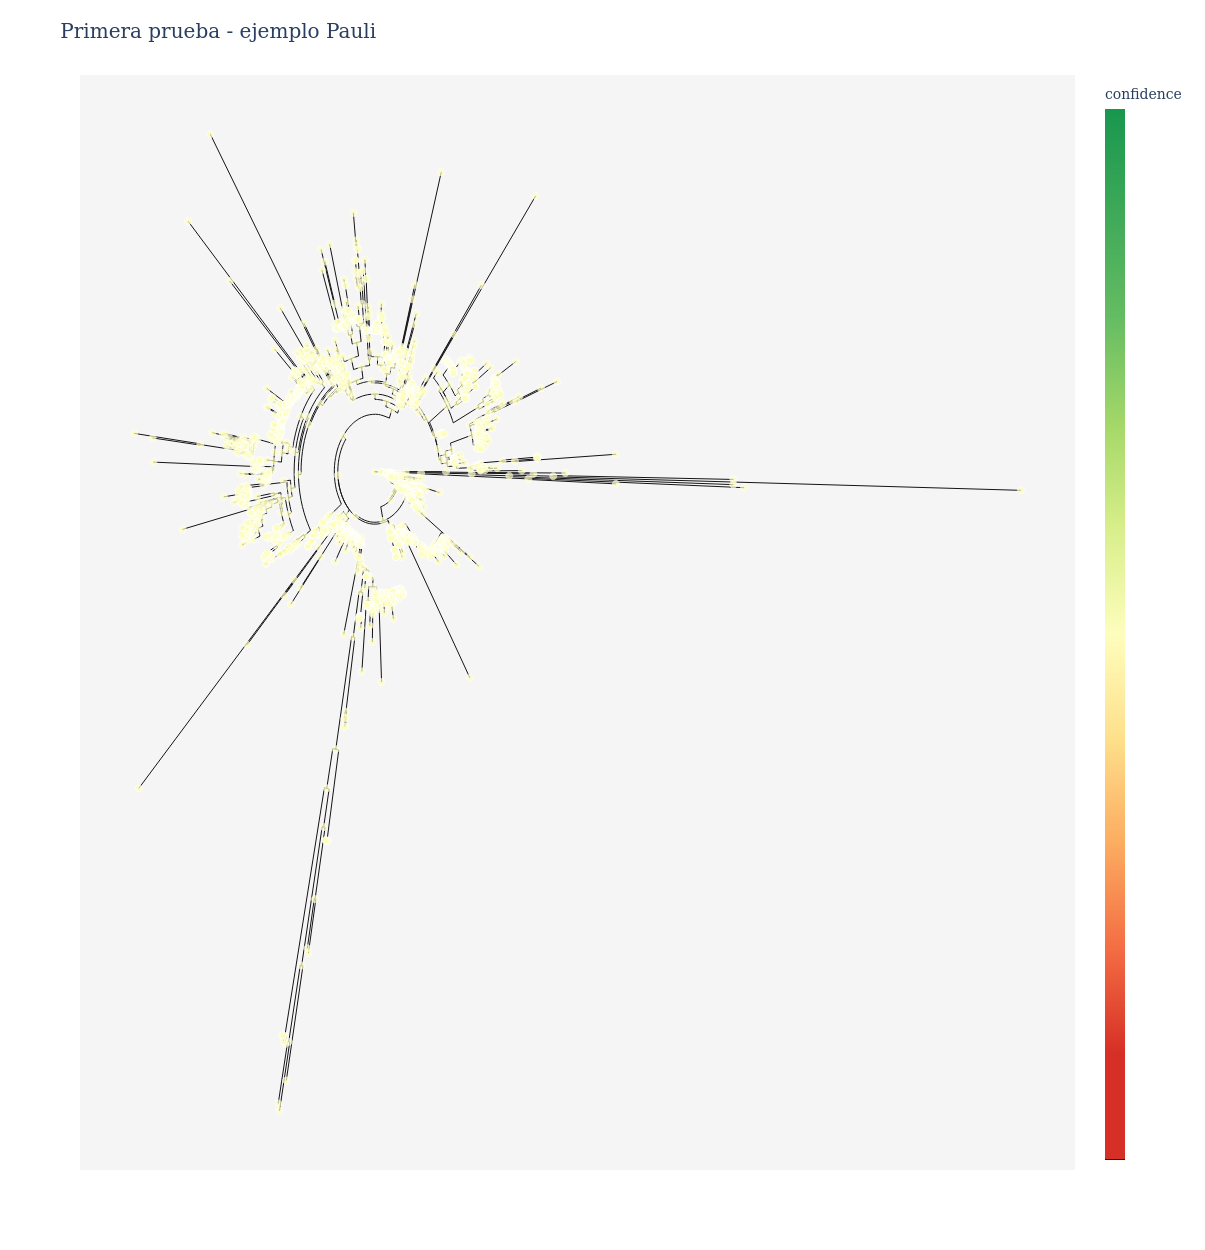

In [39]:
import plotly.io as pio

pio.show(fig)

In [40]:
fig.write_html("index.html", full_html=True)